# ABCD - It is a technique used for detecting the probability of a lesion being a melanoma.

### A - Asymmetry / Asimetría
This section refers to the asymmetry of the lesion. The more asymmetrical a lesion is, the more probable it is of being classified as a melanoma. The developed code for detecting symmetry is a product of this project. Its accuracy has not been tested, nor do is its use condoned. That is, until it has been more properly/thoroughly tested. It is experimental, however, given the constraints of this project, it is considered to be functional. A simple explanation of the procedure will be offered:

It is assumed that a nevus (e.g. mole) should be as round as possible [1]. Ideally, it is a circle. Therefore this is idealized and a comparison is made to a circle. For this, a  score is given, if this score is too high the object is rated as not symmetric; likewise the lower the score, the more circle-like the object is. 

To separate the lesion from healthy skin, a threshold must first be applied so that there aer only have two values, 0 for healthy skin and 255 for non-healthy (lesion) skin. Which corresponds to black and white respectively. Therefore, the image will become a binary image. Otsu's threshold was used for thresholding, it is less dependant on the skin tone and it is capable of adapting itself[2] to different environmental conditions. This is done to maintain the code relevant and keep maintenance low. Once Otsu's threshold is applied, the largest detected continued lesion threshold is selected. This threshold is then filled in, as to remove any non-white pixel found inside of it. Furthermore, all other thresholds are removed as to not cause problems in the next step. (The result can be observed in the figure)

The next step consists of two parts, first, the image is rotated on its centre. So that no one specific angle is favoured. Once an image is rotated on its centre the x and y-axis (its width and length) of the lesion are calculated. To do this an approximation is calculated of the centre of each column and row of the image (this can be observed in figure 2). Then the mean of all those values is taken and subtracted on both sides along the edge. The result of all these subtractions is added to a global counter that will determine whether a shape is symmetric or not. The higher the counter the less symmetric a lesion is considered.

To clarify, as of yet the code does not rule whether a lesion is a melanoma or not. That is a function reserved for a future version. 

Example:
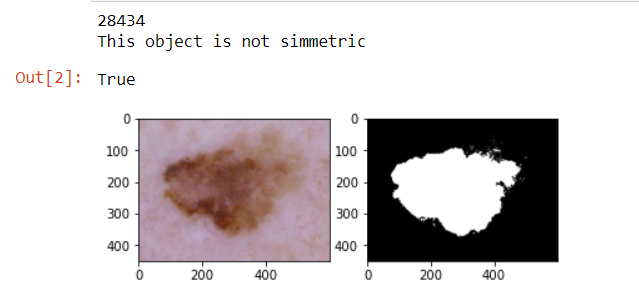

<hr style="border:5px solid gray"> </hr>


Esta sección hace referencia a la asimetría de una lesión. Entre más asimétrica es una lesión es más probable que sea clasificada como melanoma. El código de asimetría es producto de esta investigación. No se ha probado, por lo cual no se recomienda el uso de este hasta que se haya probado de una manera más completa. Sin embargo, tomando en cuenta el alcance de este proyecto se considera funcional. A continuación se presenta una explicación del funcionamiento del código.

Se asume que un nevo(lunar) debe ser lo más circular posible[1]. Idealmente un círculo. Por lo cual se idealiza este concepto y se compara la imagen con un círculo. Esto se hace por medio de un puntaje. Si este puntaje es muy alto se dice que el objeto no es simétrico y si es muy bajo se considera simétrico. Para lograr esto primeramente se le debe aplicar un umbral a la imagen de forma que la piel sana y la piel no sana (lesión) se distingan claramente. En este caso se optó por una imagen binaria en la cual el valor de 0 (negro) corresponda a piel sana y 255 (blanco) a la lesión.


Se utilizó el umbral de Otsu, ya que este tiene menos dependencia del tono de piel y es capaz de adaptarse[2]. Esto con el propósito de mantener el código relevante y que necesite poco mantenimiento a futuro. Una vez que ya se aplicó Otsu, se selecciona la lesión continua de mayor tamaño, suponiendo que este representa la mayor área de la lesión. Se rellena el umbral seleccionado, de manera que no tenga ningún pixel negro dentro de sí. Con esto listo, se deshace de los demás umbrales para que estos no provoquen problemas en la siguiente etapa. (En la figura se puede observar esto).


El siguiente paso consiste de dos partes, primero se gira la imagen con respecto a su centro. De manera que se dé una vuelta completa, esto con el objetivo de poder analizar la imagen desde diferentes ángulos, de forma que no se prefiera uno sobre otro. Segundamente se calcula un centro tanto en el eje "y" como "x". De forma que se pueda dividir la imagen a lo largo de los dos ejes para hacer el cálculo de la simetría.  Cada vez que se gira la imagen se vuelven a calcular los centros de los ejes. Para calcular la simetría se hace una resta de ambos lados de forma que si uno es más largo que el otro no se considera simétrico. Los resultados de las restas se suman a contador global que más tarde determinará si una imagen es simétrica o no.

Por el momento el código no determina si una lesión es un melanoma. Esa funcionalidad se brindará en una versión futura.

Ejemplo:
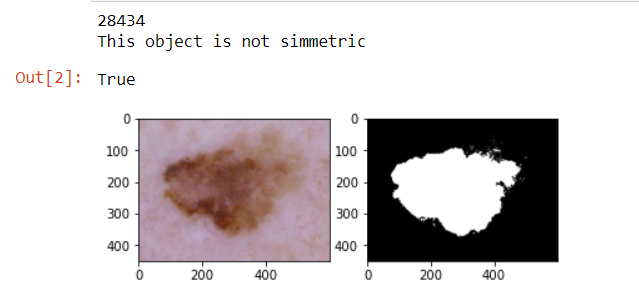


[1]Bono, A., Tomatis, S., Bartoli, C., Tragni, G., Radaelli, G., Maurichi, A., & Marchesini, R. (1999). The ABCD system of melanoma detection: A spectrophotometric analysis of the asymmetry, border, color, and dimension. Cancer: Interdisciplinary International Journal of the American Cancer Society, 85(1), 72-77.

[2]Poorna, S. S., Reddy, M. R. K., Akhil, N., Kamath, S., Mohan, L., Anuraj, K., & Pradeep, H. S. (2020). Computer Vision Aided Study for Melanoma Detection: A Deep Learning Versus Conventional Supervised Learning Approach. In Advanced Computing and Intelligent Engineering (pp. 75-83). Springer, Singapore.


In [1]:
import cv2 #Image Library
import numpy as np #Numpy library
import statistics
import imutils
from statistics import mean

def assymetry(imagePath):
    """
    Evaluate the assymetry of an image
    
    Parameters:
     imagePath[string]: The relative path to the image
     
    Returns:
        totsymmetry [float]: The total assymetry found in all the columns
    """ 
    image = cv2.imread(imagePath) #read the image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #Same image but in grayscale, this is done for calculating the threshold
    ret,thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    contours,hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)#get contours
    cv2.drawContours(thresh, contours, -1, (255,255,255), thickness=cv2.FILLED)#fill in the contour
    
    #find largest contour and remove the smaller ones
    max_area = -1
    for i in range(len(contours)):
        area = cv2.contourArea(contours[i])
        if area>max_area:
            max_area = area
    for i in range(len(contours)):
        area = cv2.contourArea(contours[i])
        if (area < max_area):
            cv2.drawContours(thresh, [contours[i]], -1, (0,0,0), -3)
    
    #caclulate symmetry
    totsymmetry = 0
    for angle in np.arange(0, 360, 15): #rotate 360 in increments of 15
        rotated = imutils.rotate_bound(thresh, angle)
        [xsym,ysym]=findsymmetry(rotated)
        totsymmetry = xsym+ysym
    return [xsym,ysym,totsymmetry]


def findsymmetry(im):
    """
    Finds the overall symmetry of the image, to do this it traverses it line by line, checking each one for it´s symmetry
    
    Parameters:
     im [2D-Matrix]: is the image, already binary and rotated
     
    Returns:
     an array containing:
      yassymetry [int]: The total assymetry found in all the columns
      xassymetry [int]: The total assymetry found in all the rows
    """ 
    [y_max,x_max] = im.shape #get width and length of the image
    x = []
    xmina=[]
    xmaxa=[]
    y_max-=1
    x_max-=1
    for y in range(y_max): #find symmtry in columns
        [x_next,xmin,xmax] = findmiddle(im[y,:],x_max)
        if(x_next != 0):
            x.append(x_next)
            xmina.append(xmin)
            xmaxa.append(xmax)
    x_line = int(mean(x))
    xassymetry = 0
    for i in range(len(xmina)):
        xassymetry += abs(abs(xmaxa[i]-x_line)-abs(xmina[i]-x_line))
    #centre line for y
    y = []
    ymina=[]
    ymaxa=[]
    for x in range(x_max):#find symmtry in rows
        [y_next,ymin,ymax] = findmiddle(im[:,x],y_max)
        if(y_next != 0):
            y.append(y_next)
            ymina.append(ymin)
            ymaxa.append(ymax)
    y_line = int(mean(y))
    yassymetry = 0
    for i in range(len(ymina)):
        yassymetry += abs(abs(ymaxa[i]-y_line)-abs(ymina[i]-y_line))
    return [yassymetry,xassymetry]


def findmiddle(line,max_):
    """
    Finds the middle in the current line
    
    Parameters:
     line [1D-Matrix]: is the current line, can be row or column
     max_ [int]: is the len of said line
     
    Returns:
     an array containing:
      1[float]: the halfway point between the first and last white pixel in a line, if there's no
      white pixel it returns 0
      min_[int]: The position of the first white pixel
      max_[int]: The position of the last white pixel
    """ 
    min_=0
    while(line[min_] != 255):
        min_+=1
        if min_>=max_:#has no white pixels
            return [0,0,0]
    while(line[max_-1] != 255):
        max_-=1
    return [((max_-min_)/2)+min_,min_,max_]
# imname = "Images/FirstImages/ISIC_0024792.png" #Name of the image to analyze, it uses relative pathing for image path
# assymetry(imname)

### Benchmark

In [2]:
import os, sys
import matplotlib.pyplot as plt


path = "Images/FirstImages"
dirs = os.listdir( path )
#for file in dirs:
#    print(file,assymetry(path+"/"+file))

### B - Border / Bordes

Border detection is one of the tasks that have been implemented in numerous ways for melanomas. Each with its advantages and disadvantages. In the previous section, the Otsu threshold was used to detect the border. However, in this section, the lesion border does not refer to detecting the border. For that Otsu will be used again.

Border in this context refers to the qualities that dermatologists look for in the border, rather than detecting it. There are two main qualities that physicians look for in possible melanoma borders, its definition and regularity.[1] Given that both of these qualities are important in melanoma diagnosis, two separate algorithms were developed for this attribute. 

First, the process for detecting poorly defined borders in the skin lesion will be described. This refers to those borders which ends are not clear. For this reason, the code is implemented with the help of a border detection function. Otsu's algorithm was used, given that the code has already been implemented in the asymmetry portion.


The code works the following way: after an initial border is detected and a threshold value has been calculated (this is obtained from the OpenCV threshold function) this value is both incremented and decremented by 10%. This causes changes in the detection of the lesion, meaning that if the lesion's border is not pronounced the change would be felt greatly. A comparison is made between both new areas. The greater the change the higher the score a lesion will have. The higher the score the more melanoma like it will be considered.

In figure 1, it can be observed how this would look on a well-defined image border. Compare that to figure 2 with less defined borders.


![Figure 1](Images/Showcase/welldefinedborders.PNG "Figure 1")
<h3><center>Figure 1: well defined borders</center></h3>

![Figure 2](Images/Showcase/poordefinedborders.PNG "Figure 2")
<h3><center>Figure 2: poorly defined borders</center></h3>

Second is the dimension, fractality or (sometimes referred to as) "jaggedness" of the borders.[1][2][3] This is a more studied and applied field for melanoma detection using computer vision. In this case, fractal dimensions were used[4][5][6][7][8] but there are other methods [9][10]. This code needs little explanation for it is compromised of two different parts. First, the image is made into a binary representation. Again, using Otsu's threshold. After this, a box-counting fractal dimension algorithm is used to estimate the fractal dimension of the image. This is done with a score. That score is usually between 1 and 2. The higher the score, the more melanoma like the lesion is considered.

<hr style="border:5px solid gray"> </hr>

La detección de bordes es una de las tareas que se han implementado de numerosas formas para los melanomas. Cada implementación con sus ventajas y desventajas. En la sección anterior, se utilizó el umbral de Otsu para detectar el borde. Sin embargo, en esta sección, el borde de la lesión no se refiere a la detección del borde. Para eso se volverá a utilizar Otsu.

Borde en este contexto se refiere a las cualidades que los dermatólogos buscan en el borde de lesiones, en lugar de detectarlo. Hay dos cualidades principales que los médicos buscan en los posibles bordes del melanoma, su definición y regularidad. [1] Dado que ambas cualidades son importantes en el diagnóstico de un melanoma, se desarrollaron dos algoritmos diferentes para este atributo.

Primero se describirá el proceso para detectar bordes mal definidos de la lesión cutánea. Esto se refiere a aquellas fronteras cuyos extremos no están claramente definidos. Por esta razón, el código se implementa con la ayuda de una función de detección de bordes. Se utilizó el algoritmo de Otsu dado que el código ya se implementó en la parte de asimetría.

El código funciona de la siguiente manera: después de que se detecta un borde inicial y se ha calculado un valor de umbral (esto se obtiene de la función de umbral de OpenCV), este valor se incrementa y disminuye en un 10%. Esto provoca cambios en la detección de la lesión, lo que significa que si el borde de la lesión no es pronunciado, el cambio se notara mucho. Se hace una comparación entre ambas nuevas áreas. Cuanto mayor sea el cambio, mayor será la puntuación que tendrá una lesión. Cuanto mayor sea la puntuación, más se considerará como melanoma.

En la figura 1, se puede observar cómo se vería esto en un borde de imagen bien definido. En comparación con la figura 2, que posee bordes menos definidos.

![Figure 1](Images/Showcase/welldefinedborders.PNG "Figura 1")
<h3><center>Figura 1: Bordes bien definidos</center></h3>

![Figure 2](Images/Showcase/poordefinedborders.PNG "Figura 2")
<h3><center>Figura 2: bordes poco definidos</center></h3>

 En segundo lugar está la dimensión, fractalidad o (a veces denominado) "irregularidad" de los bordes. [1] [2] [3]. Este es un campo más estudiado y aplicado para la detección del melanoma mediante visión artificial. En este caso, se utilizaron dimensiones fractales [4] [5] [6] [7] [8] pero existen otros métodos [9] [10]. Este código necesita poca explicación porque está compuesto por dos partes diferentes. Primero, la imagen se convierte en una representación binaria. Nuevamente, usando el umbral de Otsu. Después de esto, se utiliza un algoritmo de dimensión fractal de recuento de cajas para estimar la dimensión fractal de la imagen. Esto se hace con una puntuación. Esa puntuación suele estar entre 1 y 2. Cuanto más alta sea la puntuación (significa que este es irregular), más melanoma se considerará como la lesión.


[1]Friedman, R. J., Rigel, D. S., &amp; Kopf, A. W. (1985). Early detection of malignant melanoma: The role of physician examination and self-examination of the skin. CA: A Cancer Journal for Clinicians, 35(3), 130–151. https://doi.org/10.3322/canjclin.35.3.130 

[2]Naheed R. Abbasi, M. P. H. (2004, December 8). Early diagnosis of cutaneous melanoma. JAMA. https://jamanetwork.com/journals/jama/fullarticle/199929.

[3]S. A. Mahdiraji, Y. Baleghi and S. M. Sakhaei, "BIBS, a New Descriptor for Melanoma/Non-Melanoma Discrimination," Electrical Engineering (ICEE), Iranian Conference on, 2018, pp. 1397-1402, doi: 10.1109/ICEE.2018.8472701.

[4]Andreassi, L., Perotti, R., Rubegni, P., Burroni, M., Cevenini, G., Biagioli, M., ... & Barbini, P. (1999). Digital dermoscopy analysis for the differentiation of atypical nevi and early melanoma: a new quantitative semiology. Archives of dermatology, 135(12), 1459-1465.

[5]Carbonetto, S. H., & Lew, S. E. (2010, August). Characterization of border structure using fractal dimension in melanomas. In 2010 Annual International Conference of the IEEE Engineering in Medicine and Biology (pp. 4088-4091). IEEE.

[6]Ng, V., & Coldman, A. (1993, October). Diagnosis of melanoma with fractal dimensions. In Proceedings of TENCON'93. IEEE Region 10 International Conference on Computers, Communications and Automation (Vol. 4, pp. 514-517). IEEE.

[7]Qin, B., Ma, L., & Xu, W. (2010, June). Comparative study on boundary Structural Irregularity using Local FD and Curvature analysis for Melanoma detection. In 2010 4th International Conference on Bioinformatics and Biomedical Engineering (pp. 1-4). IEEE.

[8]Vocaturo, E., Zumpano, E., & Veltri, P. (2018, July). Features for melanoma lesions characterization in computer vision systems. In 2018 9th International Conference on Information, Intelligence, Systems and Applications (IISA) (pp. 1-8). IEEE.

[9]Lee, T. K., & Atkins, M. S. (2000, June). New approach to measure border irregularity for melanocytic lesions. In Medical Imaging 2000: Image Processing (Vol. 3979, pp. 668-675). International Society for Optics and Photonics.

[10]Aribisala, B. S., & Claridge, E. (2005, September). A border irregularity measure using a modified conditional entropy method as a malignant melanoma predictor. In International Conference Image Analysis and Recognition (pp. 914-921). Springer, Berlin, Heidelberg.

### Border Definition

In [3]:
import cv2 #Image Library
import numpy as np #Numpy library
import matplotlib.pyplot as plt #matplotlib to show images
import statistics
import imutils
from statistics import mean

def border_definition(imagePath):
    """
    Evaluate the definition of of the lesion border
    
    Parameters:
     imagePath[string]: The relative path to the image
     
    Returns:
      border_score [int]: The score given to the border, the higher this score, the lower the definition of the melanoma border
    """ 
    image = cv2.imread(imagePath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    _,thresh_high = cv2.threshold(gray,ret+ret*0.1,255,cv2.THRESH_BINARY_INV)
    _,thresh_low = cv2.threshold(gray,ret-ret*0.1,255,cv2.THRESH_BINARY_INV)
    xor = cv2.bitwise_xor(thresh_high, thresh_low)
    
    border_score = cv2.countNonZero(xor)
    return border_score


### Fractal Dimension

In [4]:
# -----------------------------------------------------------------------------
# From https://en.wikipedia.org/wiki/Minkowski–Bouligand_dimension:
#
# In fractal geometry, the Minkowski–Bouligand dimension, also known as
# Minkowski dimension or box-counting dimension, is a way of determining the
# fractal dimension of a set S in a Euclidean space Rn, or more generally in a
# metric space (X, d).
# -----------------------------------------------------------------------------

#Tomado de https://gist.github.com/viveksck/1110dfca01e4ec2c608515f0d5a5b1d1

import numpy as np
import cv2 #Image Library
import matplotlib.pyplot as plt #matplotlib to show images
import statistics
import imutils
from statistics import mean


def fractal_dimension(Z, threshold=0.9):
    """
    Estimate the fd (fractal dimension) of an image
    
    Parameters:
     Z[2D-Matrix]: Binary image
     threshold [float]: a value for consideration of fractality, in this case it is left it default
     
    Returns:
      thresh [float]: Score of the image fractal dimension, the higher, the more melanoma like it is 
    """ 

    # Only for 2d image
    assert(len(Z.shape) == 2)

    # From https://github.com/rougier/numpy-100 (#87)
    def boxcount(Z, k):
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)

        # count non-empty (0) and non-full boxes (k*k)
        return len(np.where((S > 0) & (S < k*k))[0])


    # Transform Z into a binary array
    Z = (Z < threshold)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2**np.floor(np.log(p)/np.log(2))

    # Extract the exponent
    n = int(np.log(n)/np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2**np.arange(n, 1, -1)

    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))

    # Fit the successive log(sizes) with log (counts)
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]

def binary(imagePath):
    """
    Evaluate the assymetry of an image
    
    Parameters:
     imagePath[string]: The relative path to the image
     
    Returns:
      thresh [2D-Matrix]: Representation of the image as a binary image with the lesion as white
    """ 
    image = cv2.imread(imagePath) 
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY ) 
    ret,thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    contours,hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(thresh, contours, -1, (255,255,255), thickness=cv2.FILLED)
    max_area = -1
    for i in range(len(contours)):
        area = cv2.contourArea(contours[i])
        if area>max_area:
            max_cont = contours[i]
            max_area = area
    for i in range(len(contours)):
        area = cv2.contourArea(contours[i])
        if (area < max_area):
            cv2.drawContours(thresh, contours, -1, (0,0,0), 3)
    return thresh

def image_fractality(imagePath):
    """
    Evaluate the fractal dimension of an image
    
    Parameters:
     imagePath[string]: The relative path to the image
     
    Returns:
      fd_score [float]: Score of the image fractal dimension, the higher, the more melanoma like it is 
    """ 
    bin_image = binary(imagePath)
    fd_score = fractal_dimension(bin_image)
    return fd_score

### Benchmark

In [5]:
import os, sys
import matplotlib.pyplot as plt


path = "Images/FirstImages/"
dirs = os.listdir( path )
for file in dirs:
    imname= "Images/FirstImages/"+file
#    print("File: ",file," Border_def:" , border_definition(imname)," fd:",image_fractality(imname))      


## C - Colour / Color
Multiple colours in a skin lesion are a warning sign. It is considered one of the earliest warning signs in a melanoma. While benign moles are usually a single shade of brown, a melanoma may have different shades of colour, this is called variegation.[1] This is the key for determining the C (colour) factor in ABCD.

Since this is an analysis of colour for a image processing system a the colour space must be chosen carefully. Specially given that choosing the wrong one could lead to the wrong results. In this case CIELab was chosen, since it takes into account for more colours, also, it does not depend on the medium on which is represented (screen, printer, etc) [2][3]

For this application a histogram analysis was chosen. There have been proposed several ways of estimating melanoma colours [4]. However, most of these are far too complicated and will be outside if the scope of this project. Furthermore, using histograms has proven to be effective.[5]

The process of images under this category consists of 3 main parts. First a threshold is applied to the images as to get a binary mask(representation) of the lesion. Once again, Otsu's threshold was used. Once the mask has been calculated, it must be reapplied to the original image, this is the second part. The last step is to use a histogram and calculate the change aswell as the colours the lesion has. The higher the variation the higher the value that is returned.

Some colours are more important than others, darker and blue hue colours seems to have higher implications of melanoma.[6] To account for this the algorithm is wheighted. The darker the hue the higher vale it represents to the overall result.

___

La presencia de varios colores en una lesión cutánea es una señal de advertencia. Se considera uno de los primeros signos de advertencia de un melanoma. Si bien los lunares benignos suelen tener un solo tono de marrón, un melanoma puede tener diferentes tonos de color, esto se llama abigarramiento. [1] Esta es la clave para determinar el factor C (color) en ABCD.

Dado que se trata de un análisis de color para un sistema de procesamiento de imágenes, el espacio de color debe elegirse con cuidado. Especialmente dado que elegir el incorrecto podría conducir a resultados incorrectos. En este caso se eligió CIELab, ya que toma en cuenta más colores, además, no depende del medio en el que se representa (pantalla, impresora, etc) [2] [3]

Para esta aplicación se eligió un análisis de histograma. Se han propuesto varias formas de estimar los colores del melanoma [4]. Sin embargo, la mayoría de estos son demasiado complicados y estarían fuera del alcance de este proyecto. Además, el uso de histogramas ha demostrado ser eficaz. [5]

El proceso de imágenes en esta categoría consta de 3 principales partes . Primero se aplica un umbral a las imágenes para obtener una máscara binaria (representación) de la lesión. Una vez más, se utilizó el umbral de Otsu. Una vez ya calculada la máscara, se debe volver a aplicar a la imagen original, esta es la segunda parte. El último paso es utilizar un histograma y calcular el cambio, así como los colores que tiene la lesión. Cuanto mayor sea la variación, mayor será el valor que se devuelve.

Algunos colores son más importantes que otros, los colores más oscuros y de tonos azules parecen tener mayores implicaciones del melanoma. [6] Para dar cuenta de esto, el algoritmo cuenta con un peso. Cuanto más oscuro sea el tono, mayor valor representa para el resultado general.

[1]Bono, A., Tomatis, S., Bartoli, C., Tragni, G., Radaelli, G., Maurichi, A., & Marchesini, R. (1999). The ABCD system of melanoma detection: A spectrophotometric analysis of the asymmetry, border, color, and dimension. Cancer: Interdisciplinary International Journal of the American Cancer Society, 85(1), 72-77.

[2] Kaur, A., & Kranthi, B. V. (2012). Comparison between YCbCr color space and CIELab color space for skin color segmentation. International Journal of Applied Information Systems, 3(4), 30-33.

[3]S. Sabbaghi, M. Aldeen, R. Garnavi, G. Varigos, C. Doliantis and J. Nicolopoulos, "Automated colour identification in melanocytic lesions," 2015 37th Annual International Conference of the IEEE Engineering in Medicine and Biology Society (EMBC), 2015, pp. 3021-3024, doi: 10.1109/EMBC.2015.7319028.

[4]METODO CON GRAFOS DE SUPERPIXEL    Annaby, M.H., Elwer, A.M., Rushdi, M.A. et al. Melanoma Detection Using Spatial and Spectral Analysis on Superpixel Graphs. J Digit Imaging 34, 162–181 (2021). https://doi-org.ezproxy.itcr.ac.cr/10.1007/s10278-020-00401-6

[5] Histograma   Soumya, R. S., Neethu, S., Niju, T. S., Renjini, A., & Aneesh, R. P. (2016, July). Advanced earlier melanoma detection algorithm using colour correlogram. In 2016 International Conference on Communication Systems and Networks (ComNet) (pp. 190-194). IEEE.

[6]Menzies SW, Moloney FJ, Byth K, et al. Dermoscopic Evaluation of Nodular Melanoma. JAMA Dermatol. 2013;149(6):699–709. doi:10.1001/jamadermatol.2013.2466


In [6]:
import cv2 #Image Library
import numpy as np #Numpy library
import matplotlib.pyplot as plt #matplotlib to show images

def colour(imagePath):
    """
    Evaluate the assymetry of an image
    
    Parameters:
     imagePath[string]: The relative path to the image
     
    Returns:
        score [float]: The score of the colour
    """ 
    image = cv2.imread(imagePath) #read the image
    image_CIELab = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #Same image but in grayscale, this is done for calculating the threshold
    ret,thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    contours,hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)#get contours
    cv2.drawContours(thresh, contours, -1, (255,255,255), thickness=cv2.FILLED)#fill in the contour
    
    #find largest contour and remove the smaller ones
    max_area = -1
    for i in range(len(contours)):
        area = cv2.contourArea(contours[i])
        if area>max_area:
            max_area = area
    for i in range(len(contours)):
        area = cv2.contourArea(contours[i])
        if (area < max_area):
            cv2.drawContours(thresh, contours, -1, (0,0,0), 3)
    [h,w,_] = image.shape #get width and length of the image
    # loop over the image, pixel by pixel
    for y in range(0, h):
        for x in range(0, w):
            if(thresh[y,x] == 0):
                image_CIELab[y,x,0] = 0
                image_CIELab[y,x,1] = 0
                image_CIELab[y,x,2] = 0
    histr = cv2.calcHist([image_CIELab],[0],None,[256],[1,256])
    score = 0
    for x in range(len(histr)):
        score += histr[x]*(1000/(x+50)) #take only the first 100 values
    return score

### Benchmark

In [7]:
import os, sys
import matplotlib.pyplot as plt


path = "Images/FirstImages/"
dirs = os.listdir( path )
for file in dirs:
    imname= "Images/FirstImages/"+file
#    print("File: ",file," Score:" , colour(imname)[0])


### D - Dimension / Dimensión

The last characteristic is dimension. It is sometimes also referred to as diameter[1]. For the sake of consistency, it will be regarded as a dimension here. Dermatologists generally categorize the size of potential melanoma as those whose dimension is above 6mm [1][2].

To calculate this metric area will be used. A general explanation will be offered. Once again, the image will have a threshold applied to it (again Otsu will be used) to separate healthy and non-healthy skin. With this done, the next step is to count the number of lesion pixels (white pixels) that are present.

However, there still is the matter of the representation of the physical size each pixel represents. This problem is corrected thanks to a tool that is being developed alongside this code. This aims to fix the angle and the distance from the skin to the camera, as to keep each pixel always the same size. The correlation, for the moment, has not been given. This value shall be added later on to the code. It should be noted, that without the tool, the proposed solution will not represent the actual size of the lesion, meaning that an estimated size becomes uncertain.

___

La última característica es la dimensión. A veces también se denomina diámetro [1]. En aras de la coherencia, se considerará aquí como una dimensión. Los dermatólogos generalmente clasifican el tamaño del melanoma potencial como aquellos cuya dimensión es superior a 6 mm [1] [2].

Para calcular esta métrica se utilizará area. Se ofrecerá una explicación general. Se aplicó un umbral a la imagen (de nuevo se utilizará Otsu) para separar la piel sana de la no sana. Una vez hecho esto, el siguiente paso es contar el número de píxeles de lesión (píxeles blancos) que están presentes.

Sin embargo, todavía queda la cuestión de la representación del tamaño físico que representa cada píxel. Este problema se corrige gracias a una herramienta que se está desarrollando junto con este código. Esto tiene como objetivo fijar el ángulo y la distancia desde la piel a la cámara, para mantener cada píxel siempre del mismo tamaño. La correlación, por el momento, no se ha dado. Este valor se agregará más adelante al código. Cabe señalar que sin la herramienta, la solución propuesta no representará el tamaño real de la lesión, lo que significa que el tamaño estimado se vuelve incierto.




[1]Friedman, R. J., Rigel, D. S., & Kopf, A. W. (1985). Early detection of malignant melanoma: The role of physician examination and self-examination of the skin. CA: A Cancer Journal for Clinicians, 35(3), 130–151. https://doi.org/10.3322/canjclin.35.3.130

[2]Crovari Eulufi, F., & Manzor Véliz, M. (2014). Manual de patología quirúrgica. Universidad Católica de Chile. https://www-digitaliapublishing-com.ezproxy.itcr.ac.cr/a/3826



In [8]:
import cv2 #Image Library
import numpy as np #Numpy library
import matplotlib.pyplot as plt #matplotlib to show images

size_of_pixel = 1

def dimension(imagePath):
    """
    Evaluate the assymetry of an image
    
    Parameters:
     imagePath[string]: The relative path to the image
     
    Returns:
        dimension [int]: The total size of the melanoma
    """ 
    image = cv2.imread(imagePath) #read the image
    [h,w,_] = image.shape #get width and length of the image
    
    roi = image[0:h, 0:w]

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #Same image but in grayscale, this is done for calculating the threshold
    _,thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    #get contours
    contours,hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #fill in the contour
    cv2.drawContours(thresh, contours, -1, (255,255,255), thickness=cv2.FILLED)
    #find largest area contour and remove the smaller ones
    max_area = -1
    for i in range(len(contours)):
        area = cv2.contourArea(contours[i])
        if area>max_area:
            max_cont = contours[i]
            max_area = area
    for i in range(len(contours)):
        area = cv2.contourArea(contours[i])
        if (area < max_area):
            cv2.drawContours(thresh, contours, -1, (0,0,0), 3)
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    tot = 0
    for y in range(h):
        for x in range(w):
            if(thresh[y][x]) == 255:
                tot +=1
    global size_of_pixel
    dimension = tot * size_of_pixel
    return dimension

### Benchmark

In [9]:
import os, sys
import matplotlib.pyplot as plt


path = "Images/FirstImages"
dirs = os.listdir( path )
#for file in dirs:
#    print(file,dimension(path+"/"+file))

### Pipeline

In [ ]:
import os, sys
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd

#path = "Images/FirstImages"
path = "Images/Paint"
#dirs = os.listdir( path )
#dirs = ["assymetrytest.png"]
dirs = ["M02-F1-001.jpg"]
results= []
for file in dirs:
    curr_img = {}
    curr_img['Image'] = path+"/"+file
    now = datetime.now()
    curr_img['Date'] = now.strftime("'%d/%m/%Y %H:%M:%S")
    print("Start: "+now.strftime("%d/%m/%Y %H:%M:%S"))
    
    curr_img['Start_Assymetry'] = now.strftime("'%d/%m/%Y %H:%M:%S")
    assymetry_res = assymetry(path+"/"+file)
    curr_img['Assymetry_x'] = assymetry_res[0]
    curr_img['Assymetry_y'] = assymetry_res[1]
    curr_img['Assymetry_tot'] = assymetry_res[2]
    now = datetime.now()
    curr_img['End_Assymetry'] = now.strftime("'%d/%m/%Y %H:%M:%S")
    
    curr_img['Start_Border_def'] = now.strftime("'%d/%m/%Y %H:%M:%S")
    curr_img['Border_def'] = border_definition(path+"/"+file)
    now = datetime.now()
    curr_img['End_Border_def'] = now.strftime("'%d/%m/%Y %H:%M:%S")
    
    curr_img['Start_Border_frc'] = now.strftime("'%d/%m/%Y %H:%M:%S")
    curr_img['Border_frc'] = image_fractality(path+"/"+file)
    now = datetime.now()
    curr_img['End_Border_frc'] = now.strftime("'%d/%m/%Y %H:%M:%S")
    
    curr_img['Start_Border_colour'] = now.strftime("'%d/%m/%Y %H:%M:%S")
    curr_img['Colour'] = colour(path+"/"+file)[0]
    now = datetime.now()
    curr_img['End_Border_colour'] = now.strftime("'%d/%m/%Y %H:%M:%S")
    
    curr_img['Start_Border_dimension'] = now.strftime("'%d/%m/%Y %H:%M:%S")
    curr_img['Dimension'] = dimension(path+"/"+file)
    now = datetime.now()
    curr_img['End_Border_dimension'] = now.strftime("'%d/%m/%Y %H:%M:%S")
    
    results.append(curr_img)

now = datetime.now()
print("End: "+now.strftime("%d/%m/%Y %H:%M:%S"))
df = pd.DataFrame.from_dict(results)
df.to_csv (r'results/'+now.strftime("%d-%m-%Y_%H-%M")+'.csv', index = False, header=True)

Start: 27/09/2021 09:32:06


In [12]:
import cv2 #Image Library
import numpy as np #Numpy library
import statistics
import imutils
from statistics import mean
import matplotlib.pyplot as plt

def testThrsh(imagePath):
    """
    Evaluate the assymetry of an image
    
    Parameters:
     imagePath[string]: The relative path to the image
     
    Returns:
        totsymmetry [float]: The total assymetry found in all the columns
    """ 
    image = cv2.imread(imagePath) #read the image
    print(image.shape)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #Same image but in grayscale, this is done for calculating the threshold
    ret,thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    contours,hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)#get contours
    cv2.drawContours(thresh, contours, -1, (255,255,255), thickness=cv2.FILLED)#fill in the contour
   
    
    #find largest contour and remove the smaller ones
    max_area = -1
    for i in range(len(contours)):
        area = cv2.contourArea(contours[i])
        if area>max_area:
            max_area = area
        
    for i in range(len(contours)):
        area = cv2.contourArea(contours[i])
        if (area < max_area):
            cv2.drawContours(thresh, [contours[i]], -1, (0,0,0), -3)
    return thresh
    

imname = "Images/Paint/M01-F1-001.jpg" #Name of the image to analyze, it uses relative pathing for image path
testThrsh(imname)

(4000, 6000, 3)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [13]:
#import os, sys
#import matplotlib.pyplot as plt
#import cv2

#path = "Images/Paint"
#path = "Images/FirstImages"
#dirs = os.listdir( path )
#for file in dirs:
#    cv2.imwrite("results/imagetest2/"+file,testThrsh(path+"/"+file))